In [1]:
# @title Copyright 2022 The Cirq Developers
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Qubit Picking

When running a circuit on a noisy quantum hardware device, the choice and even ordering of hardware qubits used directly affects how reliably the device measures a correct result. This notebook covers some of the available qubit error information that can be useful for picking good hardware qubits to run your circuit on.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/hardware/qubit_picking"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/hardware/qubit_picking.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/hardware/qubit_picking.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/hardware/qubit_picking.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [2]:
# @title Setup { vertical-output: true, display-mode: "form" }
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq

import cirq_google
import numpy as np
from matplotlib import pyplot as plt

installing cirq...
     |████████████████████████████████| 66 kB 2.4 MB/s 
     |████████████████████████████████| 57 kB 2.1 MB/s 
     |████████████████████████████████| 641 kB 41.6 MB/s 
     |████████████████████████████████| 1.8 MB 53.2 MB/s 
     |████████████████████████████████| 594 kB 45.6 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 145 kB 69.9 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 220 kB 38.2 MB/s 
     |████████████████████████████████| 1.0 MB 51.1 MB/s 
     |████████████████████████████████| 229 kB 54.8 MB/s 
     |████████████████████████████████| 44 kB 2.4 MB/s 
     |████████████████████████████████| 243 kB 49.9 MB/s 
     |███████

/usr/local/lib/python3.7/dist-packages/cirq/ops/gateset.py:377: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  'v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If'


## State of qubit selection in Cirq

Cirq assumes that circuits you intend to run on quantum hardware (virtual or otherwise) is able to be placed on the device, and assumes that you are able to perform placement by hand. The information in this notebook serves to help you identify which qubits are the best to use, but it is up to you to map the qubits in your circuit to the "good" qubits available on the device..

## Error characterization data

Cirq provides characterization error data that is intended to represent actual Google quantum hardware as accurately as possible. The primary use of this data is for creating a `cirq.NoiseModel` for use in a [Quantum Virtual Machine](/cirq/simulate/quantum_virtual_machine), but it also provides information on what qubits are the best to use for your circuit. 

The following code demonstrates how to load that noise data as a `cirq_google.devices.GoogleNoiseProperties` object, which specifies the available data.

In [3]:
processor_id = "rainbow"
cal = cirq_google.engine.load_median_device_calibration(processor_id)
noise_props = cirq_google.noise_properties_from_calibration(cal)

### One qubit gate Pauli error data

Pauli error defines decoherence of a single qubit in one of the Pauli [channels](/cirq/representing_noise) X, Y, or Z. If the errors are distributed in the uniform distribution over all three axes, the probability of applying an erroneous Pauli gate X, Y, or Z will be the Pauli error divided by three. See page 11 of [this Supplementary Information document](https://arxiv.org/abs/1910.11333){:.external} for more on Pauli error. 

Below is the single qubit Pauli error for the four gates supported by the Rainbow processor, pulled from the `gate_pauli_errors` attribute of the noise properties object.

One qubit error data: gate_pauli_errors
There are 4 different single qubit gates supported


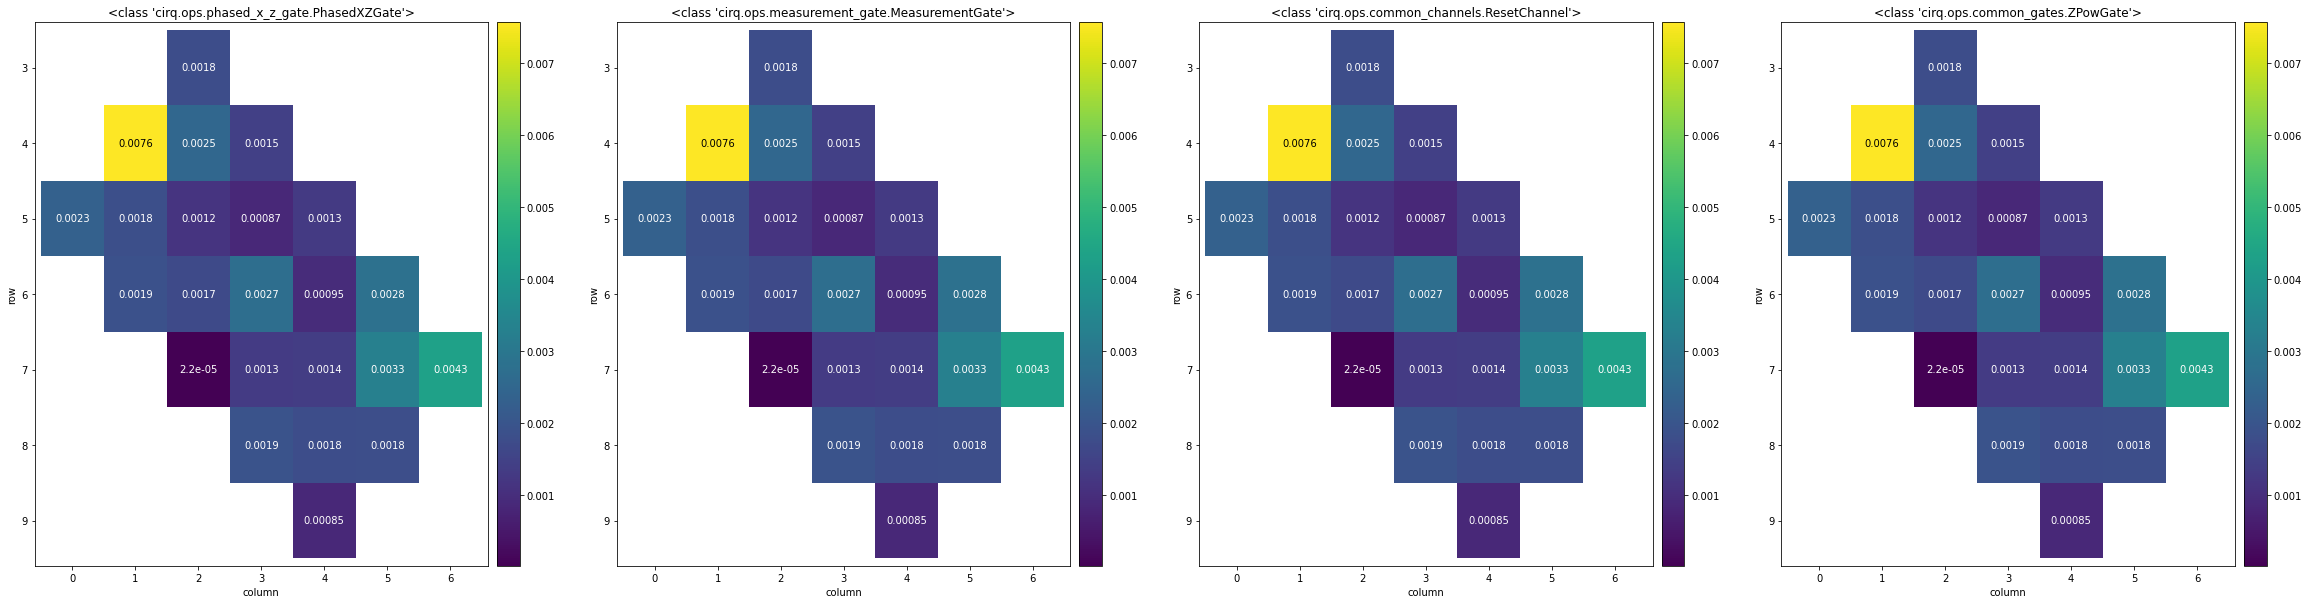

In [4]:
print(f"One qubit error data: gate_pauli_errors")
single_qubit_gates = noise_props.single_qubit_gates()
print(f"There are {len(single_qubit_gates)} different single qubit gates supported")
fig, axes = plt.subplots(1, 4, figsize=(40, 10))
for gate, ax in zip(single_qubit_gates, axes.flat):
    measures = {
        op_id.qubits: pauli_error
        for op_id, pauli_error in noise_props.gate_pauli_errors.items()
        if op_id.gate_type == gate
    }
    ax.set_title(str(gate))
    _ = cirq.Heatmap(measures).plot(ax)

fig.show()

The provided error data shows identical Pauli error for all gate types, with relatively higher error for qubits `(4,1)` and `(7,6)`. Qubit `(7,2)` is noticeably lower error than the others, and could be prioritized to be used for many single-qubit operations.

### Two qubit gate Pauli error data

The two qubit gates also cause Pauli decoherence, which is also stored in the `gate_pauli_errors` attribute. 

Two qubit error data: gate_pauli_errors


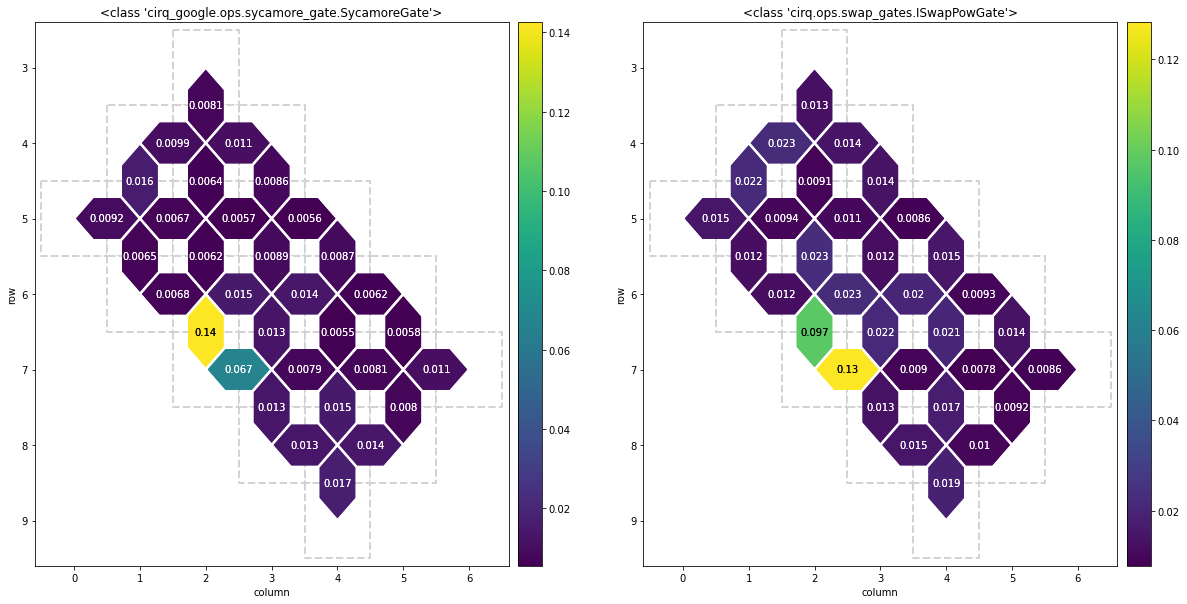

In [5]:
two_qubit_gates = noise_props.two_qubit_gates()
print(f"Two qubit error data: gate_pauli_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = iter(axes)
for gate in two_qubit_gates:
    measures = {
        op_id.qubits: pauli_error
        for op_id, pauli_error in noise_props.gate_pauli_errors.items()
        if op_id.gate_type == gate
    }
    if measures:
        ax = next(axes)
        ax.set_title(str(gate))
        _ = cirq.TwoQubitInteractionHeatmap(measures).plot(ax)

fig.show()

This Pauli data informs that the qubit pairs `(6,2)-(7,2)` and `(7,2)-(7,3)` should be avoided at all costs, but the other qubits are roughly comparable.

### Two qubit gate FSim error

FSim error represents [coherent](cirq/representing_noise#channels) two-qubit error that cannot be represented by Pauli channels (that is, it results from entanglement). Instead, it is represented as an additional `cirq.PhasedFSimGate` with small parameters that would be applied to a given qubit pair after any two-qubit gate's execution.

The following example takes the norm of a couple of the parameters, as a rough approximate representation of the goodness of qubit pairs relative to one another. 

Two qubit error data: fsim_errors


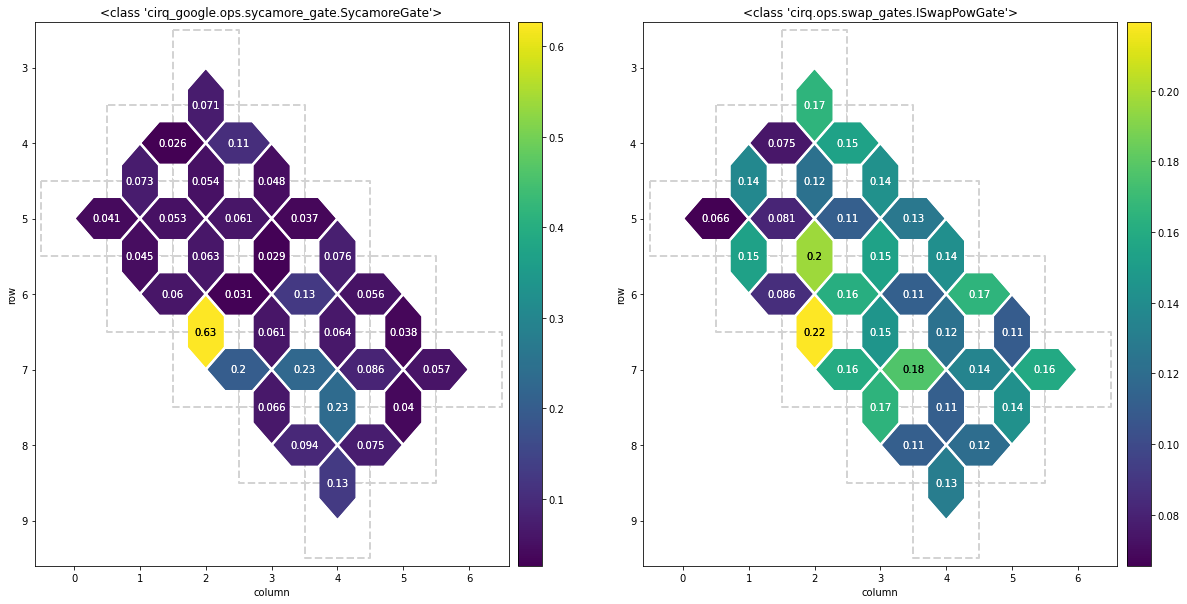

In [6]:
print(f"Two qubit error data: fsim_errors")
two_qubit_gates = noise_props.two_qubit_gates()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = iter(axes)
for gate in two_qubit_gates:
    measures = {
        op_id.qubits: fsim_refit_gate
        for op_id, fsim_refit_gate in noise_props.fsim_errors.items()
        if op_id.gate_type == gate
    }
    if measures:
        ax = next(axes)
        # Norm the Fsim refit gate parameters as an approximate of how good a qubit is.
        measures = {
            qubits: np.linalg.norm([fsim_refit_gate.theta, fsim_refit_gate.phi])
            for qubits, fsim_refit_gate in measures.items()
        }
        ax.set_title(str(gate))
        _ = cirq.TwoQubitInteractionHeatmap(measures).plot(ax)

fig.show()

This fsim data would influence you to avoid the `(6,2)-(7,2)` qubit pair, and prefer the top left of the grid for high-priority qubit pairs  (those that have two-qubit gates executed on them many times in your circuit).

### Readout error

Readout error manifests as a measurement of $|1\rangle$ when it should have been $|0\rangle$, or vice versa. Note that this is different from the Pauli error induced by the `cirq.MeasurementGate`, which affects the quantum state _after_ the operation is executed and doesn't affect the measurement result. Readout error is far more impactful due to the magnitude of the error and the fact that all measurements are typically terminal (so anything after a `MeasurementGate` is unused). 

One qubit error data: readout_errors


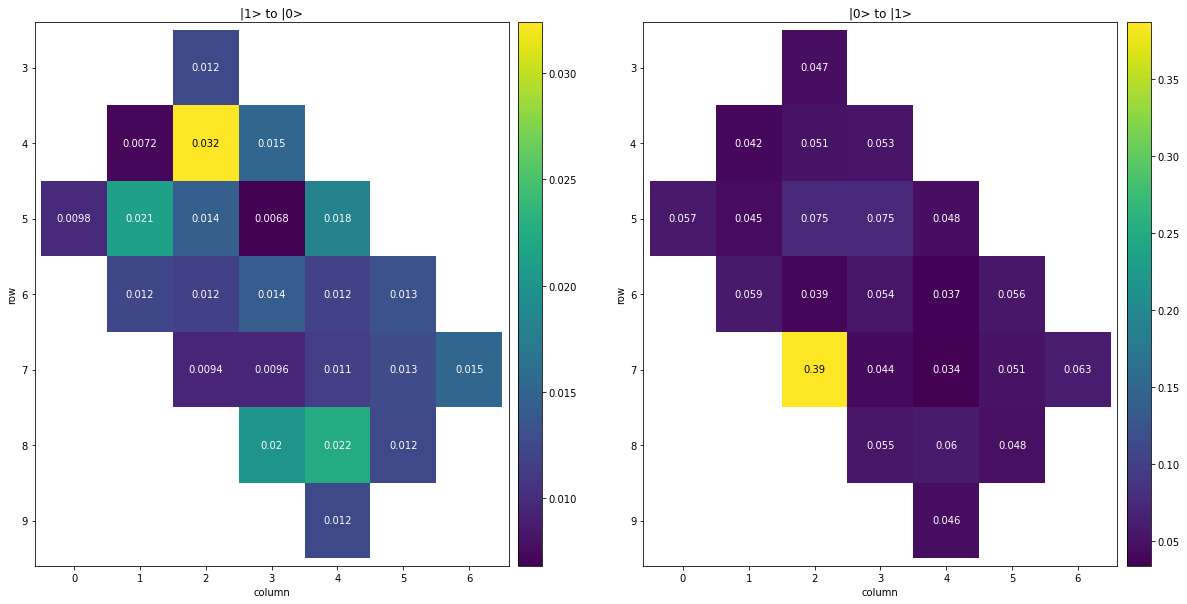

In [10]:
print(f"One qubit error data: readout_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, ax, title in zip(range(2), axes.flat, ["|1> to |0>", "|0> to |1>"]):
    measures = {
        qubit: readout_error[i] for qubit, readout_error in noise_props.readout_errors.items()
    }
    ax.set_title(title)
    _ = cirq.Heatmap(measures).plot(ax)
fig.show()

This readout data indicates that you definitely want to avoid qubits `(7,2)` and `(4,2)`, and maybe `(8,3)`,`(8,4)` and `(5,1)`.

## Overall qubit picking strategy

Even though the single Pauli qubit data preferred qubit `(7,2)`, the coupled pairs attached to that qubit have abysmal error rates, meaning it should be avoided at all costs. Qubit `(4,1)` has some interesting properties in that its two-qubit gates are quite good, and so is its readout, but not its single-qubit Pauli error. It may be useful to use this qubit in an entangled system where only the other qubits have single-qubit gates applied to them. All of the other gates are roughly comparable going off these error rates. As noted, the choice of which hardware qubits have which circuit operations applied to them is ultimately up to your discretion.

# Summary

Cirq provides the following error types which serve to represent an actual Google quantum hardware device as accurately as currently possible: 
- One- and two-qubit Pauli error for each `cirq.Gate` supported by the device
- Two-qubit Fsim error for each supported two-qubit gate that models non-Pauli error. 
- Readout error for each qubit that models error in measurements.  
While often used to create [QVM](/cirq/simulate/quantum_virtual_machine)s, this data is also useful in the process of finding good qubits to use. By avoiding high error qubits whenever possible, you can maximize the reliability of your circuit. 

If you're working with an actual device that may experience drift, or a change in behavior over time, you may need to use more advanced noise compensation strategies, which you can read about in the [Noise](/cirq/noise) category.